In [1]:
%load_ext autoreload
%autoreload 2

# Toy dataset creation

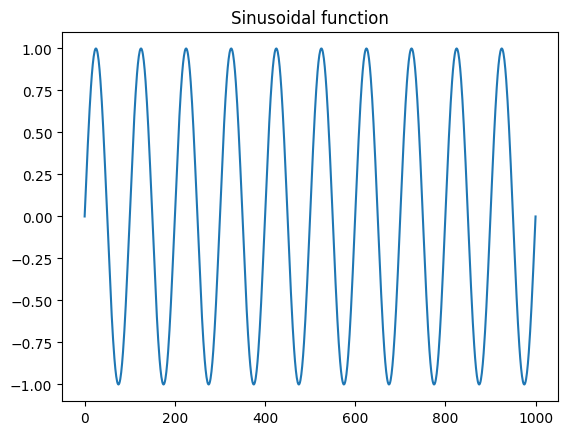

In [2]:
import numpy as np
import matplotlib.pyplot as plt

N = 1000
freq = 10 / N

x = np.linspace(0.0, N, N)

sinus = np.sin(2 * np.pi * x * freq)

plt.title(("Sinusoidal function"))
plt.plot(x, sinus)
plt.show()

# ABBA Visualization

In [3]:
from src.abba import ABBA

abba = ABBA(
    increment_threshold=0.03, max_length=200, min_cluster_size=5, max_cluster_size=6
)

nb of linear pieces:  41


Text(0.5, 1.0, 'Reconstruction after compression')

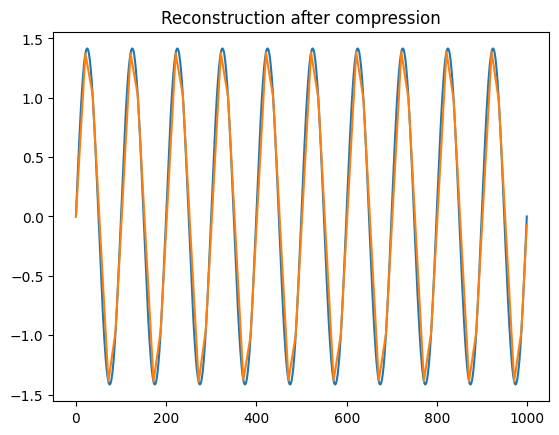

In [4]:
standardized_sinus = abba.standardize(sinus)
linear_pieces = abba.get_linear_pieces(standardized_sinus)
print("nb of linear pieces: ", len(linear_pieces))
plt.plot(abba.standardize(sinus))
plt.plot(abba.unfold_linear_pieces(linear_pieces))
plt.title("Reconstruction after compression")

Learn transform and apply reverse transform to the data and visualize the results

string_representation='facbdacbdacbdacbdacbdacbdacbdacbdacbdacbe'


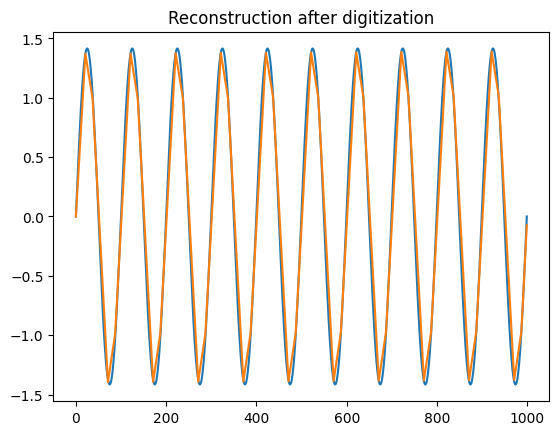

In [5]:
standardized_sinus = abba.standardize(sinus)

abba.learn_transform(standardized_sinus)

string_representation = abba.apply_transform_to_str(standardized_sinus)
print(f"{string_representation=}")

reconstructed_linear = abba.apply_inverse_transform_from_str(string_representation)

plt.plot(abba.standardize(sinus))
plt.plot(reconstructed_linear)
plt.title("Reconstruction after digitization")
plt.show()

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

DTW after compressession:  0.015999723436661277
DTW after digitization:  0.016951041113943244


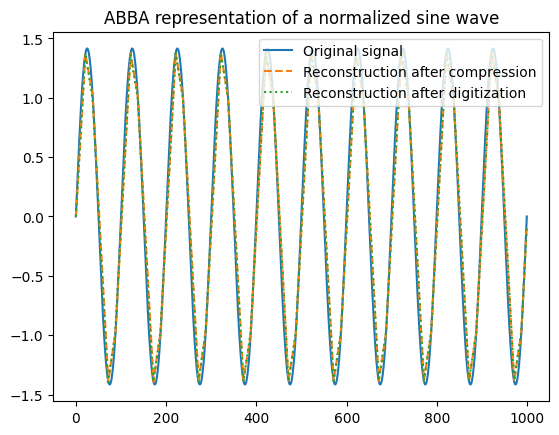

In [6]:
from dtw import dtw

print(
    "DTW after compressession: ",
    dtw(
        abba.standardize(sinus), abba.unfold_linear_pieces(linear_pieces)
    ).normalizedDistance,
)
print(
    "DTW after digitization: ",
    dtw(abba.standardize(sinus), reconstructed_linear).normalizedDistance,
)

plt.plot(abba.standardize(sinus))


plt.plot(abba.unfold_linear_pieces(linear_pieces), linestyle="--")
plt.plot(reconstructed_linear, linestyle=":")
plt.title("ABBA representation of a normalized sine wave")
plt.legend(
    [
        "Original signal",
        "Reconstruction after compression",
        "Reconstruction after digitization",
    ],
    loc="upper right",
)

# ABBA Training

Train, test split and learn transform only on the train data

In [7]:
from src.forecasting.dataset import get_datasets_and_loaders

batch_size = 2


test_split_ratio = 0.2
sequence_length = 10


abba = ABBA(increment_threshold=0.01, max_length=10)

time_series = abba.standardize(sinus)

raw_train, raw_test, train_loader, test_loader = get_datasets_and_loaders(
    time_series,
    batch_size=batch_size,
    test_split_ratio=test_split_ratio,
    sequence_length=sequence_length,
    num_workers=0,
    abba=abba,
)

Average time series length per symbol: 8.333333333333334


Train a model on the transformed data

In [8]:
from src.forecasting.models import ABBAForecastingLSTM
from src.forecasting.training import train_loop, accuracy, test_loop
import torch

model = ABBAForecastingLSTM(
    language_size=len(abba.language),
    hidden_size=16,
    num_layers=2,
)


loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_loop(
        model,
        train_loader,
        optimizer,
        loss_function,
        accuracy,
        device=torch.device("cpu"),
    )

    test_loss, test_accuracy = test_loop(
        model,
        test_loader,
        loss_function,
        accuracy,
        device=torch.device("cpu"),
    )

    print(
        f"Epoch {epoch} - Train Loss: {train_loss:.3f} - Train Accuracy: {train_accuracy:.3f} - Test Loss: {test_loss:.3f} - Test Accuracy: {test_accuracy:.3f}"
    )

Epoch 0 - Train Loss: 0.070 - Train Accuracy: 0.035 - Test Loss: 1.475 - Test Accuracy: 0.083
Epoch 1 - Train Loss: 0.066 - Train Accuracy: 0.070 - Test Loss: 1.445 - Test Accuracy: 0.083
Epoch 2 - Train Loss: 0.066 - Train Accuracy: 0.151 - Test Loss: 1.375 - Test Accuracy: 0.167
Epoch 3 - Train Loss: 0.058 - Train Accuracy: 0.291 - Test Loss: 1.290 - Test Accuracy: 0.292
Epoch 4 - Train Loss: 0.051 - Train Accuracy: 0.349 - Test Loss: 1.214 - Test Accuracy: 0.375
Epoch 5 - Train Loss: 0.045 - Train Accuracy: 0.488 - Test Loss: 1.163 - Test Accuracy: 0.458
Epoch 6 - Train Loss: 0.043 - Train Accuracy: 0.605 - Test Loss: 1.111 - Test Accuracy: 0.500
Epoch 7 - Train Loss: 0.034 - Train Accuracy: 0.640 - Test Loss: 1.058 - Test Accuracy: 0.542
Epoch 8 - Train Loss: 0.038 - Train Accuracy: 0.663 - Test Loss: 1.002 - Test Accuracy: 0.625
Epoch 9 - Train Loss: 0.024 - Train Accuracy: 0.733 - Test Loss: 0.973 - Test Accuracy: 0.500
Epoch 10 - Train Loss: 0.025 - Train Accuracy: 0.721 - Test 

Evaluate the results both quantitatively and qualitatively

Autoregressive prediction DTW:  0.034393775126833066
Non Autoregressive prediction DTW:  0.1343591055965496


Text(0.5, 1.0, 'ABBA-LSTM forecasting on sinusoidal function')

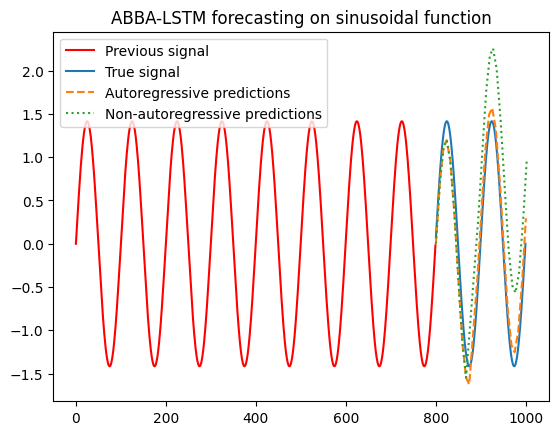

In [9]:
from src.forecasting.training import forecast

autoregressive_predictions = forecast(
    model, test_loader.dataset, auto_regressive=True, abba=abba
)
non_autoregressive_predictions = forecast(
    model, test_loader.dataset, auto_regressive=False, abba=abba
)


print(
    "Autoregressive prediction DTW: ",
    dtw(autoregressive_predictions, raw_test).normalizedDistance,
)
print(
    "Non Autoregressive prediction DTW: ",
    dtw(non_autoregressive_predictions, raw_test).normalizedDistance,
)

plt.plot(raw_train, color="red")
plt.plot(np.arange(len(raw_train), len(raw_train) + len(raw_test)), raw_test)
plt.plot(
    np.arange(len(raw_train), len(raw_train) + len(autoregressive_predictions)),
    autoregressive_predictions,
    linestyle="--",
)
plt.plot(
    np.arange(len(raw_train), len(raw_train) + len(non_autoregressive_predictions)),
    non_autoregressive_predictions,
    linestyle=":",
)
plt.legend(
    [
        "Previous signal",
        "True signal",
        "Autoregressive predictions",
        "Non-autoregressive predictions",
    ]
)
plt.title("ABBA-LSTM forecasting on sinusoidal function")

# Comparison with classical LSTM

In [10]:
from src.forecasting.dataset import get_datasets_and_loaders

batch_size = 16


test_split_ratio = 0.2
sequence_length = 83

time_series = abba.standardize(sinus)

raw_train, raw_test, train_loader, test_loader = get_datasets_and_loaders(
    time_series,
    batch_size=batch_size,
    test_split_ratio=test_split_ratio,
    sequence_length=sequence_length,
    num_workers=0,
    abba=None,
)

In [11]:
from src.forecasting.models import RegressionForecastingLSTM
from src.forecasting.training import train_loop, mse, test_loop
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = RegressionForecastingLSTM(
    hidden_size=64,
    num_layers=2,
).to(device)

loss_function = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

for epoch in range(num_epochs):
    train_loss, train_mse = train_loop(
        model,
        train_loader,
        optimizer,
        loss_function,
        mse,
        device=device,
    )

    test_loss, test_mse = test_loop(
        model,
        test_loader,
        loss_function,
        mse,
        device=device,
    )

    print(
        f"Epoch {epoch} - Train Loss: {train_loss*1000:.3f} - Train MSE: {train_mse*1000:.3f} - Test Loss: {test_loss*1000:.3f} - Test MSE: {test_mse*1000:.3f}"
    )

Epoch 0 - Train Loss: 0.237 - Train MSE: 467.635 - Test Loss: 5.348 - Test MSE: 81.274
Epoch 1 - Train Loss: 0.010 - Train MSE: 22.114 - Test Loss: 0.135 - Test MSE: 2.097
Epoch 2 - Train Loss: 0.000 - Train MSE: 1.021 - Test Loss: 0.016 - Test MSE: 0.261
Epoch 3 - Train Loss: 0.000 - Train MSE: 0.109 - Test Loss: 0.003 - Test MSE: 0.045
Epoch 4 - Train Loss: 0.000 - Train MSE: 0.041 - Test Loss: 0.003 - Test MSE: 0.040
Epoch 5 - Train Loss: 0.000 - Train MSE: 0.030 - Test Loss: 0.002 - Test MSE: 0.035
Epoch 6 - Train Loss: 0.000 - Train MSE: 0.029 - Test Loss: 0.002 - Test MSE: 0.035
Epoch 7 - Train Loss: 0.000 - Train MSE: 0.019 - Test Loss: 0.001 - Test MSE: 0.019
Epoch 8 - Train Loss: 0.000 - Train MSE: 0.015 - Test Loss: 0.001 - Test MSE: 0.015
Epoch 9 - Train Loss: 0.000 - Train MSE: 0.019 - Test Loss: 0.002 - Test MSE: 0.029
Epoch 10 - Train Loss: 0.000 - Train MSE: 0.024 - Test Loss: 0.001 - Test MSE: 0.012
Epoch 11 - Train Loss: 0.000 - Train MSE: 0.011 - Test Loss: 0.001 - Te

Autoregressive prediction DTW:  0.015274204585396862
Non Autoregressive prediction DTW:  0.0010561853469989964


Text(0.5, 1.0, 'LSTM forecasting on sinusoidal function trained on raw data')

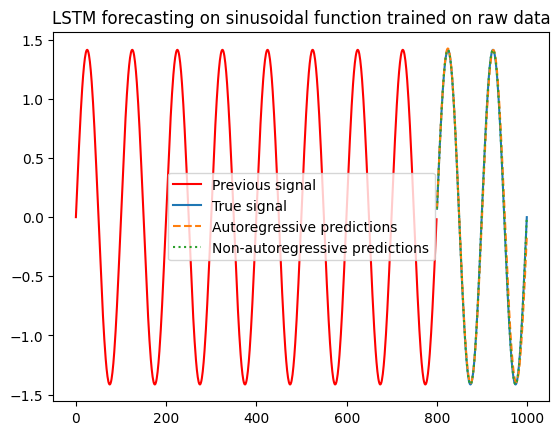

In [12]:
test_data = np.array([test_loader.dataset[i][1] for i in range(len(test_loader.dataset))])  # type: ignore

model.to(torch.device("cpu"))

autoregressive_predictions = forecast(
    model, test_loader.dataset, auto_regressive=True, abba=None
)
non_autoregressive_predictions = forecast(
    model, test_loader.dataset, auto_regressive=False, abba=None
)

print(
    "Autoregressive prediction DTW: ",
    dtw(autoregressive_predictions, raw_test).normalizedDistance,
)
print(
    "Non Autoregressive prediction DTW: ",
    dtw(non_autoregressive_predictions, raw_test).normalizedDistance,
)


plt.plot(raw_train, color="red")
plt.plot(np.arange(len(raw_train), len(raw_train) + len(raw_test)), raw_test)
plt.plot(
    np.arange(len(raw_train), len(raw_train) + len(autoregressive_predictions)),
    autoregressive_predictions,
    linestyle="--",
)
plt.plot(
    np.arange(len(raw_train), len(raw_train) + len(non_autoregressive_predictions)),
    non_autoregressive_predictions,
    linestyle=":",
)
plt.legend(
    [
        "Previous signal",
        "True signal",
        "Autoregressive predictions",
        "Non-autoregressive predictions",
    ]
)
plt.title("LSTM forecasting on sinusoidal function trained on raw data")